# Analyzing neighborhoods of Madrid, Spain

This notebook is the base of the analysis explained in the document "Capstone Report".

### Required modules

In [1]:
from geopy.geocoders import Photon
from bs4 import BeautifulSoup
import pandas as pd
import requests
import numpy as np
from dotenv import load_dotenv, find_dotenv
import os
import matplotlib.pyplot as plt
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

### Extraction of data and preprocessing

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_neighborhoods_of_Madrid"
html = requests.get(url).text

In [3]:
soup = BeautifulSoup(html, "html.parser")

In [4]:
cols = ['District', 'Neighborhood']

In [5]:
data = {i:[] for i in cols}

for row in soup.find('table').find_all('tr'):
    if len(row.find_all('td')) == 0:  # skip blank rows
        continue
        
    elif len(row.find_all('td')) == 5:  # if the row starts with the district name
        
        for cell in row.find_all('td'):
            try:
                bracket = cell.text[-2]
            except:
                bracket = ''

            if  bracket == ')':
                district = cell.text.split(' ')[0]
            elif cell.text.strip() != '' and not cell.text.strip().isdigit() and cell.text.strip() != '[[]]':
                neighborhood = cell.text.strip()
            
    else:  # if the row only has heighborhood name
        
        for cell in row.find_all('td'):
            if cell.text.strip() != '' and not cell.text.strip().isdigit() and cell.text.strip() != '[[]]':
                neighborhood = cell.text.strip()
            
    data['District'].append(district)
    data['Neighborhood'].append(neighborhood)

In [6]:
df_neighborhoods = pd.DataFrame(data, columns=cols)
df_neighborhoods.head(10)

,District,Neighborhood
0,Centro,Palacio
1,Centro,Embajadores
2,Centro,Cortes
3,Centro,Justicia
4,Centro,Universidad
5,Centro,Sol
6,Arganzuela,Imperial
7,Arganzuela,Acacias
8,Arganzuela,Chopera
9,Arganzuela,Legazpi


In [7]:
# funtion to calculate latitude and longitude of each neighborhood in Madrid
geolocator = Photon()

def get_lat_lng(district, neighborhood):
    location = geolocator.geocode("{}, {}, Madrid, España".format(district, neighborhood))
    try:
        lat = location.latitude
        lng = location.longitude
    except:
        lat = np.nan
        lng = np.nan
    return lat, lng

In [8]:
df_neighborhoods = pd.concat([df_neighborhoods,
                              df_neighborhoods.apply(lambda x: get_lat_lng(x['District'],x['Neighborhood']),
                                                          axis=1, 
                                                          result_type='expand')],
                             axis=1)

df_neighborhoods.rename(columns={0:'Latitude', 1:'Longitude'}, inplace=True)

In [9]:
# after calculating latitude and longitude there is a null value
df_neighborhoods.isna().sum()

District        0
Neighborhood    0
Latitude        1
Longitude       1
dtype: int64

In [10]:
df_neighborhoods.dropna(axis=0, inplace=True)

In [11]:
df_neighborhoods.head()

,District,Neighborhood,Latitude,Longitude
0,Centro,Palacio,40.417821,-3.715111
1,Centro,Embajadores,40.421058,-3.707185
2,Centro,Cortes,40.416389,-3.696463
3,Centro,Justicia,40.424246,-3.693508
4,Centro,Universidad,40.422753,-3.709849


In [12]:
# foursquare credentials
load_dotenv(find_dotenv())
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
VERSION = '20210102'
LIMIT = 100

In [13]:
def getNearbyVenues(neighborhoods, latitudes, longitudes, radius=500):
    """
        Returns a dataframe of nearby venues in each neighborhood
    """
    venues_list=[]
    for neighborhood, lat, lng in zip(neighborhoods, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            neighborhood, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
# get venue data for each neighborhood
df_venues = getNearbyVenues(df_neighborhoods['Neighborhood'],
                            df_neighborhoods['Latitude'],
                            df_neighborhoods['Longitude']
                           )

In [15]:
df_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Palacio,40.417821,-3.715111,Palacio Real de Madrid,40.417940,-3.714259,Palace
1,Palacio,40.417821,-3.715111,Plaza de la Almudena,40.416320,-3.713777,Plaza
2,Palacio,40.417821,-3.715111,Santa Iglesia Catedral de Santa María la Real ...,40.415767,-3.714516,Church
3,Palacio,40.417821,-3.715111,Plaza de Oriente,40.418326,-3.712196,Plaza
4,Palacio,40.417821,-3.715111,Zuccaru,40.417179,-3.711674,Ice Cream Shop


### Exploratory data analysis

In [16]:
# get latitude and longitude of Madrid to show the location of the neighborhoods on a map
location = geolocator.geocode('Madrid centro, España')
latitude = location.latitude
longitude = location.longitude

In [17]:
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=11)

for lat, lng, label in zip(df_neighborhoods['Latitude'], df_neighborhoods['Longitude'], df_neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  

map_madrid

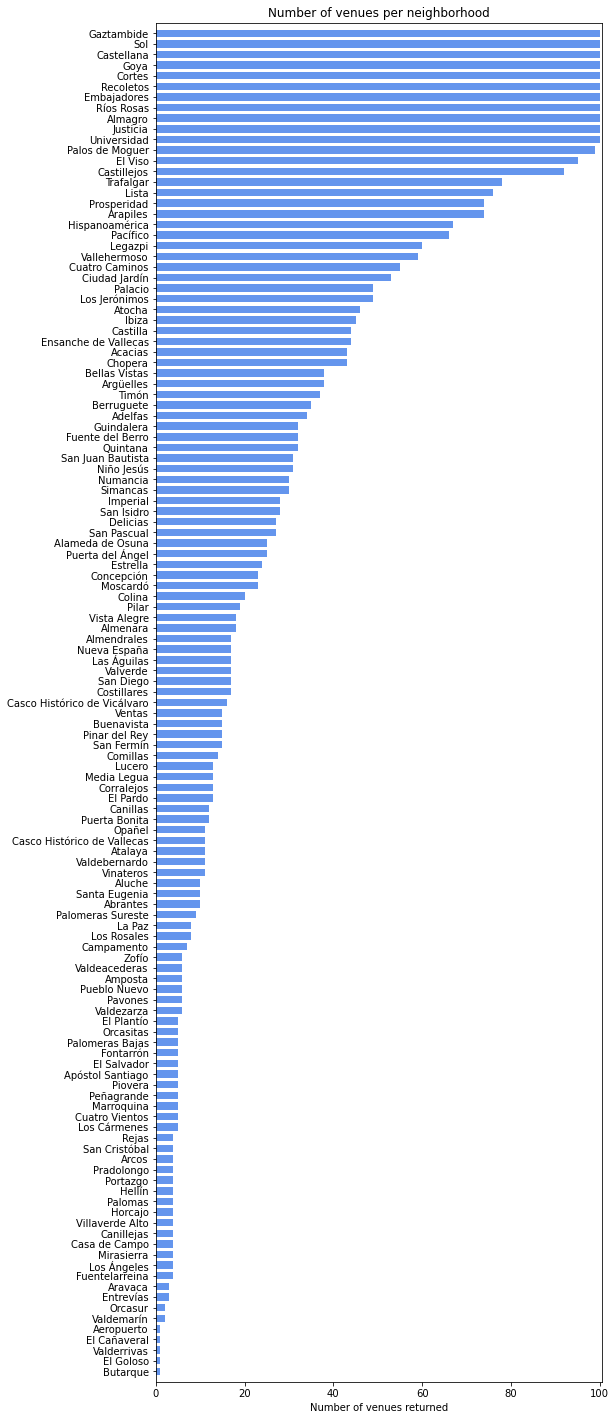

In [18]:
# graph how many results were obtained for each neighborhood
tmp = df_venues.groupby('Neighborhood')['Venue Category'].count().sort_values()

plt.figure(figsize=(8,25))
plt.barh(
    y=tmp.index,
    width=tmp.values,
    height=0.7,
    color='cornflowerblue'
)
plt.margins(x=0.005, y=0.005)
plt.title('Number of venues per neighborhood')
plt.xlabel('Number of venues returned')
plt.show()

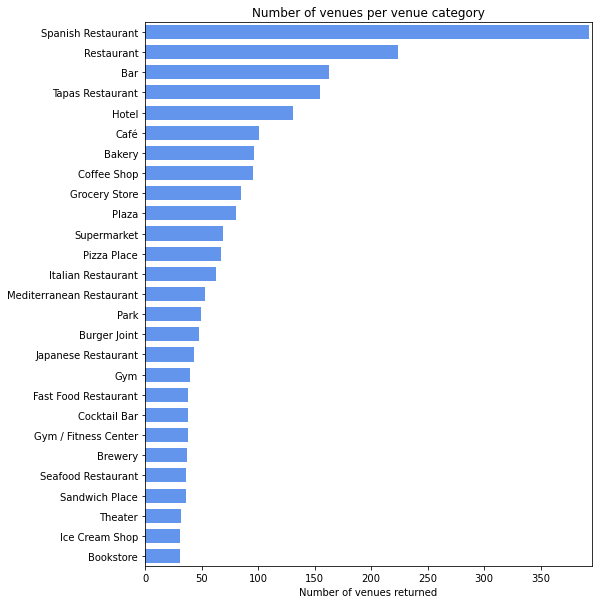

In [19]:
# graph the frequency of each venue category (only most common categories)
tmp = df_venues.groupby('Venue Category')['Venue'].count().sort_values()
tmp = tmp[tmp>30]

plt.figure(figsize=(8,10))
plt.barh(
    y=tmp.index,
    width=tmp.values,
    height=0.7,
    color='cornflowerblue'
)
plt.margins(x=0.005, y=0.005)
plt.title('Number of venues per venue category')
plt.xlabel('Number of venues returned')
plt.show()

### Clusterization of the neighborhoods based on venue information

In [20]:
# treat each venue category as a feature
df_venues_onehot_name = pd.get_dummies(df_venues['Venue Category'])
df_venues_onehot_name['Neighborhood'] = df_venues['Neighborhood']

# order the columns
fixed_columns = [df_venues_onehot_name.columns[-1]] + list(df_venues_onehot_name.columns[:-1])
df_venues_onehot_name = df_venues_onehot_name[fixed_columns]

# group by neighborhood calculating the average
df_venues_onehot_name = df_venues_onehot_name.groupby('Neighborhood').mean().reset_index()

df_venues_onehot_name.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Airport,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store
0,Abrantes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,Acacias,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046512,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0
2,Adelfas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,Aeropuerto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,Alameda de Osuna,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [21]:
df_venues_onehot = df_venues_onehot_name.drop('Neighborhood', axis=1)

# search for the best number of clusters using elbow method
inertia = []

for i in range(1,11):
    model = KMeans(n_clusters=i, random_state=123)
    model.fit(df_venues_onehot)
    
    inertia.append(model.inertia_)

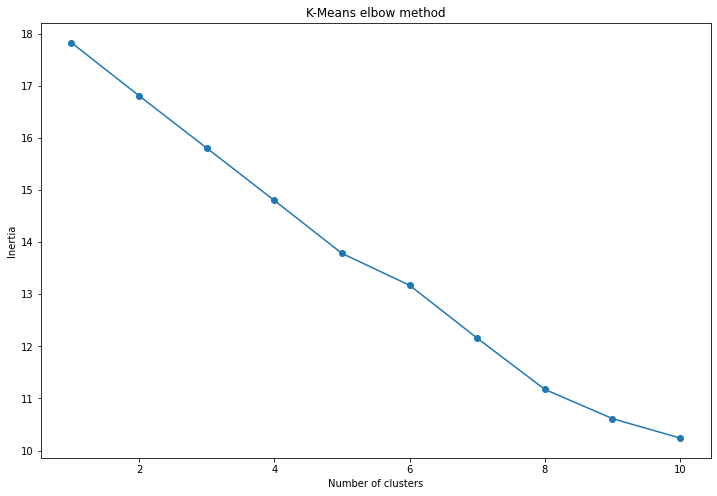

In [22]:
plt.figure(figsize=(12,8))
plt.plot(range(1,11), inertia, marker='o')

plt.title("K-Means elbow method")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")

plt.show()

It seems that 8 is a good number of clusters to segment the neighborhoods of Madrid.

In [23]:
# create the final model
n_clusters = 8
model = KMeans(n_clusters=n_clusters, random_state=123).fit(df_venues_onehot)

In [24]:
# dataframe to store results
cols = ['Neighborhood', 
      '1st most common venue', 
      '2nd most common venue',
      '3rd most common venue',
      '4th most common venue',
      '5th most common venue']

madrid_segmented = pd.DataFrame(columns=cols)

madrid_segmented['Neighborhood'] = df_venues_onehot_name['Neighborhood']

for i in madrid_segmented.index:  # (% of venues returned that are of that category)
    for j in range(1,6):
        madrid_segmented.loc[i,cols[j]] = df_venues_onehot_name.iloc[i,1:].sort_values().index[-j]\
        +' ('+ str(round(df_venues_onehot_name.iloc[i,1:].sort_values()[-j], 2)) + ')'

madrid_segmented.head()

,Neighborhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
0,Abrantes,Bakery (0.2),Soccer Field (0.2),Gym / Fitness Center (0.1),Pizza Place (0.1),Park (0.1)
1,Acacias,Bar (0.09),Tapas Restaurant (0.07),Spanish Restaurant (0.07),Pizza Place (0.07),Art Gallery (0.05)
2,Adelfas,Supermarket (0.06),Grocery Store (0.06),Tapas Restaurant (0.06),Bar (0.06),Fast Food Restaurant (0.06)
3,Aeropuerto,Business Service (1.0),Women's Store (0.0),Escape Room (0.0),Food Court (0.0),Food & Drink Shop (0.0)
4,Alameda de Osuna,Restaurant (0.08),Tapas Restaurant (0.08),Hotel (0.08),Bakery (0.08),Cocktail Bar (0.04)


In [25]:
# update final dataframe
madrid_segmented = madrid_segmented.merge(df_neighborhoods[['Latitude', 'Longitude', 'Neighborhood']], 
                                            on='Neighborhood',
                                            how='inner')
madrid_segmented['Label'] = model.labels_

madrid_segmented.head()

,Neighborhood,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue,Latitude,Longitude,Label
0,Abrantes,Bakery (0.2),Soccer Field (0.2),Gym / Fitness Center (0.1),Pizza Place (0.1),Park (0.1),40.380998,-3.727985,3
1,Acacias,Bar (0.09),Tapas Restaurant (0.07),Spanish Restaurant (0.07),Pizza Place (0.07),Art Gallery (0.05),40.404075,-3.705957,0
2,Adelfas,Supermarket (0.06),Grocery Store (0.06),Tapas Restaurant (0.06),Bar (0.06),Fast Food Restaurant (0.06),40.401903,-3.670958,0
3,Aeropuerto,Business Service (1.0),Women's Store (0.0),Escape Room (0.0),Food Court (0.0),Food & Drink Shop (0.0),40.494838,-3.574081,7
4,Alameda de Osuna,Restaurant (0.08),Tapas Restaurant (0.08),Hotel (0.08),Bakery (0.08),Cocktail Bar (0.04),40.457581,-3.587975,0


### Results

In [26]:
# create map of clustered neighborhoods
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lng, poi, cluster in zip(madrid_segmented['Latitude'], madrid_segmented['Longitude'], madrid_segmented['Neighborhood'], madrid_segmented['Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [27]:
# analyze venues categories of each cluster
for i in madrid_segmented['Label'].sort_values().unique():
    print("##### Cluster {} #####".format(i))
    display(madrid_segmented[madrid_segmented['Label']==i].iloc[:,1:6])
    print('\n')

##### Cluster 0 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
1,Bar (0.09),Tapas Restaurant (0.07),Spanish Restaurant (0.07),Pizza Place (0.07),Art Gallery (0.05)
2,Supermarket (0.06),Grocery Store (0.06),Tapas Restaurant (0.06),Bar (0.06),Fast Food Restaurant (0.06)
4,Restaurant (0.08),Tapas Restaurant (0.08),Hotel (0.08),Bakery (0.08),Cocktail Bar (0.04)
5,Spanish Restaurant (0.14),Restaurant (0.13),Mediterranean Restaurant (0.05),Bar (0.04),Japanese Restaurant (0.04)
6,Chinese Restaurant (0.17),Hotel (0.06),Library (0.06),Coffee Shop (0.06),Restaurant (0.06)
...,...,...,...,...,...
121,Coffee Shop (0.18),Breakfast Spot (0.12),Soccer Field (0.06),Spanish Restaurant (0.06),Snack Place (0.06)
122,Pizza Place (0.13),Soccer Field (0.13),Grocery Store (0.13),Garden (0.07),Bar (0.07)
123,Restaurant (0.25),Pizza Place (0.25),Train (0.25),Train Station (0.25),Farm (0.0)
124,Playground (0.09),Restaurant (0.09),Flower Shop (0.09),Plaza (0.09),Food & Drink Shop (0.09)




##### Cluster 1 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
20,Grocery Store (1.0),Farmers Market (0.0),Escape Room (0.0),Event Space (0.0),Exhibit (0.0)




##### Cluster 2 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
15,Spanish Restaurant (0.36),Restaurant (0.09),Bus Station (0.09),Paella Restaurant (0.09),Chinese Restaurant (0.09)
35,Spanish Restaurant (0.31),Restaurant (0.15),Fast Food Restaurant (0.08),Hotel (0.08),Bar (0.08)
43,Spanish Restaurant (0.38),Restaurant (0.23),Plaza (0.15),Tapas Restaurant (0.08),Government Building (0.08)
63,Spanish Restaurant (0.25),Restaurant (0.12),Food & Drink Shop (0.12),Park (0.12),Athletics & Sports (0.12)
115,Spanish Restaurant (0.5),Breakfast Spot (0.17),Tapas Restaurant (0.17),Art Studio (0.17),Fast Food Restaurant (0.0)
119,Spanish Restaurant (0.33),Soccer Field (0.33),Supermarket (0.17),Asian Restaurant (0.17),Farmers Market (0.0)
126,Spanish Restaurant (0.5),Beer Garden (0.17),Park (0.17),Athletics & Sports (0.17),Women's Store (0.0)




##### Cluster 3 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
0,Bakery (0.2),Soccer Field (0.2),Gym / Fitness Center (0.1),Pizza Place (0.1),Park (0.1)
9,Park (0.33),Bakery (0.17),Bar (0.17),Other Repair Shop (0.17),Café (0.17)
10,Restaurant (0.2),Park (0.2),Soccer Field (0.2),Grocery Store (0.2),Metro Station (0.2)
12,Castle (0.33),Bus Stop (0.33),Park (0.33),Event Space (0.0),Exhibit (0.0)
49,Park (0.33),Pizza Place (0.33),Gym / Fitness Center (0.33),Women's Store (0.0),Farm (0.0)
57,Park (0.25),Music Venue (0.25),Gym (0.25),Pharmacy (0.25),Women's Store (0.0)
59,Spanish Restaurant (0.25),Pizza Place (0.25),Soccer Stadium (0.25),Park (0.25),Farm (0.0)
69,Pizza Place (0.25),Restaurant (0.12),Track Stadium (0.12),Supermarket (0.12),Chinese Restaurant (0.12)
72,Park (0.6),Plaza (0.2),Brewery (0.2),Women's Store (0.0),Farmers Market (0.0)
85,Toy / Game Store (0.2),Food & Drink Shop (0.2),Bar (0.2),Park (0.2),Optical Shop (0.2)




##### Cluster 4 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
118,Mediterranean Restaurant (1.0),Women's Store (0.0),Farmers Market (0.0),Event Space (0.0),Exhibit (0.0)




##### Cluster 5 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
41,Toll Booth (1.0),Farmers Market (0.0),Escape Room (0.0),Event Space (0.0),Exhibit (0.0)




##### Cluster 6 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
42,Shoe Store (1.0),Women's Store (0.0),Embassy / Consulate (0.0),Food & Drink Shop (0.0),Food (0.0)




##### Cluster 7 #####


,1st most common venue,2nd most common venue,3rd most common venue,4th most common venue,5th most common venue
3,Business Service (1.0),Women's Store (0.0),Escape Room (0.0),Food Court (0.0),Food & Drink Shop (0.0)


### Neighborhoods found in cluster 2:

In [28]:
madrid_segmented['Neighborhood'][madrid_segmented['Label']==2]

15           Atalaya
35        Corralejos
43          El Pardo
63            La Paz
115    Valdeacederas
119       Valdezarza
126            Zofío
Name: Neighborhood, dtype: object